## An very quick practical introduction to Bayesian inference

The log-posterior $\mathcal{L}(\mathbf{\theta})$ as a function of model parameters $\mathbf{\theta}$ is the product of the likelihood $L(\mathbf{d} | \mathbf{\theta})$ of the data $\mathbf{d}$ and the prior $\pi(\mathbf{\theta})$:

$\mathcal{L}(\mathbf{\theta}) = L(\mathbf{d} | \mathbf{\theta}) \pi(\mathbf{\theta})$

We usually provide to samplers or profilers the log-posterior, with is then the sum of the log-likelihood and the log-prior.

If the likelihood is Gaussian, the loglikelihood is just $- \chi^{2} / 2$ with $\chi^{2}(\mathbf{d} | \mathbf{\theta}) = (\mathbf{d} - \mathbf{t}(\mathbf{\theta}))^{T} C^{-1} (\mathbf{d} -  \mathbf{t}(\mathbf{\theta}))^{T}$, where $\mathbf{t}(\mathbf{\theta})$ is the theory for the data $\mathbf{d}$ and $C^{-1}$ the inverse data covariance matrix.

### Example

Linear model, $\mathbf{t}(a, b) = a \mathbf{x} + b$.

In [1]:
import numpy as np

size = 10
x = np.linspace(0., 1., size)

def theory(a, b):
    return a * x + b

# Data mean = true theory
mean = theory(0.5, 0.5)

# Covariance
covariance = np.eye(size)
covariance += 0.01 * np.ones(covariance.shape)

precision = np.linalg.inv(covariance)

rng = np.random.RandomState(seed=42)
# Generate data vector
data = rng.multivariate_normal(mean, covariance)

In [2]:
def chi2(args):
    diff = data - theory(*args)
    return diff.dot(precision).dot(diff)


def logprior(args):
    # Uniform prior
    a, b = args
    return 0.


def logposterior(args):
    return - 0.5 * chi2(args) + logprior(args)

In [3]:
from scipy import optimize

# Minimize chi2
init = [0., 0.]
bounds = [(-0.5, 0.5)] * len(init)

result = optimize.minimize(chi2, init, method='SLSQP', bounds=bounds)
print('a, b = {:.2f}, {:.2f}'.format(*result.x))

a, b = 0.32, 0.42


a, b = 0.31 \pm 0.98, 0.43 \pm 0.59


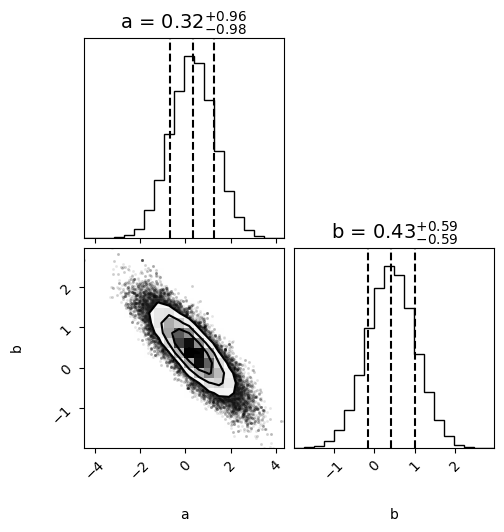

In [4]:
# Sample posterior
import emcee
import corner

nsteps = 19000
ndim = len(bounds)
nwalkers = 4 * ndim

def sample():
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    start = [[rng.normal(v, (b[1] - b[0]) / 10.) for v, b in zip(init, bounds)] for i in range(nwalkers)]
    sampler.run_mcmc(start, nsteps)
    samples = sampler.get_chain(flat=True)
    # Look at samples, remove burnin
    samples = samples[len(samples) // 2:]
    # Take mean (or median) and covariance of samples
    mean = np.mean(samples, axis=0)
    covariance = np.cov(samples, rowvar=False)
    print('a, b = {0[0]:.2f} \pm {1[0]:.2f}, {0[1]:.2f} \pm {1[1]:.2f}'.format(mean, np.diag(covariance)**0.5))
    return samples
    
samples = sample()
fig = corner.corner(samples, labels=['a', 'b'], quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_kwargs={'fontsize': 14})

a, b = 0.17 \pm 0.70, 0.49 \pm 0.49


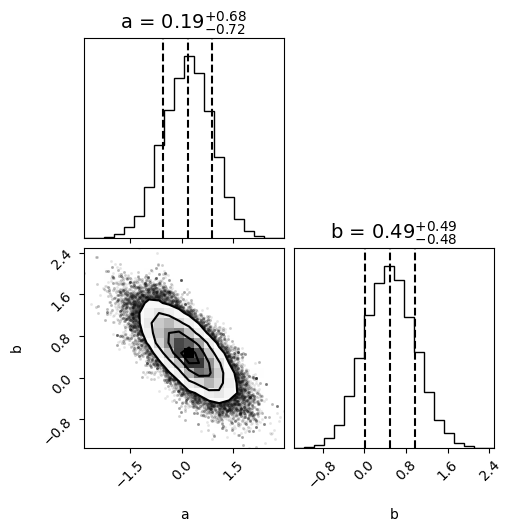

In [5]:
def logprior(args):
    # Let's add a Gaussian prior on a, centered on 0, variance 1
    a, b = args
    return - a**2 / (2. * 1**2)

samples2 = sample()
fig = corner.corner(samples2, labels=['a', 'b'], quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_kwargs={'fontsize': 14})
# See how the posterior on a is tighter and shifted towards 0 with the prior

In [6]:
# Metropolis-Hastings, see https://fr.wikipedia.org/wiki/Algorithme_de_Metropolis-Hastings
proposal = np.diag([1., 1.])  # proposal covariance matrix
x_current = rng.multivariate_normal(init, proposal)
logp_current = logposterior(x_current)

samples3 = []

for i in range(50000):
    x_new = rng.multivariate_normal(x_current, proposal)
    logp_new = logposterior(x_new)
    alpha = np.exp(logp_new - logp_current)
    if alpha >= 1. or rng.uniform(0., 1.) < alpha:
        x_current, logp_current = x_new, logp_new
    samples3.append(x_current)

samples3 = np.array(samples3)
samples3 = samples3[len(samples3) // 2:]

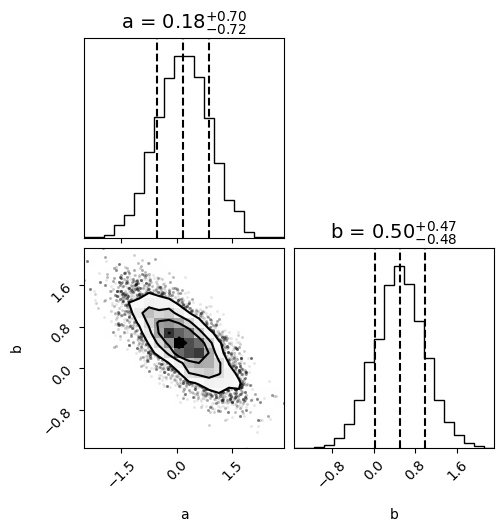

In [7]:
fig = corner.corner(samples3, labels=['a', 'b'], quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_kwargs={'fontsize': 14})